In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from rawPy import rawPy as rp
import os

cwd = os.getcwd()

In [ ]:
#Choose the preferred backend for interactive plotting
%matplotlib qt

##########################  
**Date Run:** 2/3/18 Scuderi   
**Date Reduced:** 3/7/18 Scuderi  
##########################  
**Material:** Wenchuan Drillin project WFSD-3P-6  
**Configuration:** Double-Direct Shear 5x5 5x5 small grooves side blocks  
**Normal stress:** 12MPa  
**Shear velocity:** 10µm/s  
**Velocity steps:** 0.3µm/s-1mm/s  
**Slide-hold-slide:** 10-10000  
**Notes:**  
W1 = 8.24g  
W2 = 8.28g  

In [2]:
#LOAD DATA
exp_name = os.path.join(cwd, 'example', 'b754s03wen6_12')
data = rp.load_data('%s'%exp_name,pandas=True)

------------------------------------------------------
|                Name|           Unit|        Records|
-----------------------------------------------------
|              V-LVDT|           (mm)|         223102|
|              H-LVDT|           (mm)|         223102|
|              V-LOAD|           (kN)|         223102|
|              H-LOAD|           (kN)|         223102|
|                Time|          (sec)|         223102|
|              Record|            (.)|         223102|
------------------------------------------------------


In [3]:
# rename these two columns that will not change throughout the analysis
time_s = data.Time
records_na = data.Record # record must always be the last col when saving files

### 1. Calculate Normal Stress 

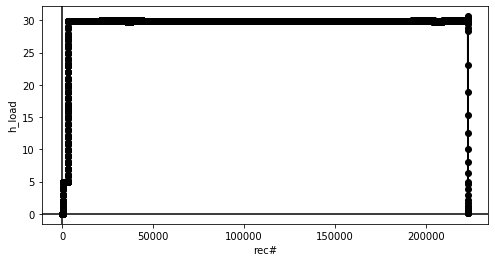

In [4]:
# PLOT
rp.plot(data.Record,data['H-LOAD'],'rec#','h_load')

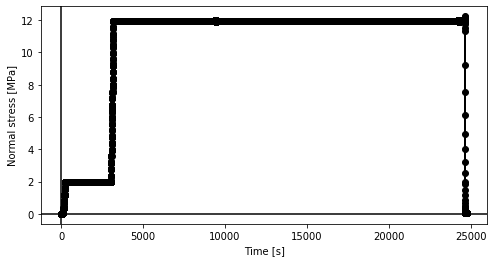

In [5]:
#############  normal load ############ 
#### Normal load is applied at record

beg_row_h = 342

######################################
# zero the data
h_load = rp.zero(data['H-LOAD'],beg_row_h)
# remove noise before load is applied 
h_load[:beg_row_h] = h_load[:beg_row_h]*0
# calculate stress for DDS 5x5
h_load =  h_load/(1000*0.0025)
#add a small number to normal stress 
#so that we aren't dividing by 0 anywhere to calculate mu 
normal_stress_MPa = h_load + 1e-7
del h_load

rp.plot(data.Time,normal_stress_MPa,'Time [s]','Normal stress [MPa]')

### 2. Calculate Shear Stress ####

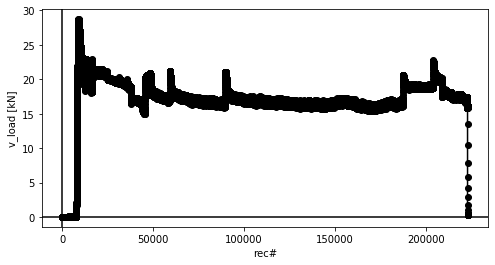

In [6]:
# PLOT
rp.plot(data.Record,data['V-LOAD'],'rec#','v_load [kN]')

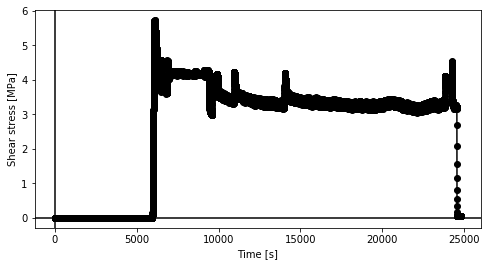

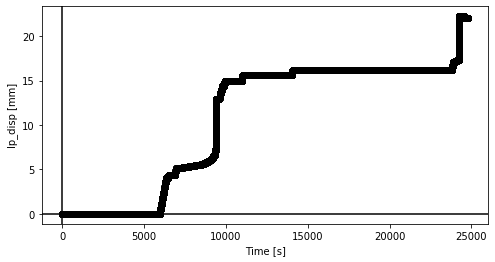

In [7]:
#### Vertical stress ###
#### This is the point at which the ram contacted the blocks and load shear loading began

beg_row_v = 7625

##################################

# ZERO DATA
v_load = rp.zero(data['V-LOAD'],beg_row_v)
# add in force from the central block due to gravity 
v_load = v_load + 0.044 #[kN]
# remove noise before load is applied
v_load[:beg_row_v]= v_load[:beg_row_v]*0
# calculate stress for DDS 5x5
shear_stress_MPa = v_load/(2*1000*0.0025)
del v_load

#### vertical disp ####
lp_disp_mm = rp.zero(data['V-LVDT'],beg_row_v)
lp_disp_mm[:beg_row_v] = lp_disp_mm[:beg_row_v]*0
lp_disp_mm = lp_disp_mm*-1

rp.plot(data.Time,shear_stress_MPa,'Time [s]','Shear stress [MPa]')
rp.plot(data.Time,lp_disp_mm,'Time [s]', 'lp_disp [mm]')

**If necessary offset the data**

In [8]:
# OFFSET data 
# takes as input row1, row2, col 
#example
#row_1 = 89726
#row_2 = 89737
#lp_disp_mm = rp.offset(lp_disp_mm,row_1,row_2)
#

### 3. Correct for elastic strech of the vertical frame   

| Verical stiffness | applied load | k[MPa/mm] | calibration date | 
| --- | --- | --- | --- |  
| 359.75 [kN/mm] | < 50 [kN] | 116.801 [MPa/mm] | 19/11/2015 | 
| 928.5 [kN/mm] | > 50 [kN] | 301.461 [MPa/mm] | 19/11/2015 | 

Note:  
1. These values are calculated for a 5x5[cm] shear surface  
2. Stiffness is non linear at low applied loads  
TO DO: implement a function that corrects for non-linear stiffness


In [9]:
# Elastic correction for the stretch of the vertical frame # 
k = 166.801 #[MPa/mm]
ec_disp_mm = rp.ElasticCorrection(shear_stress_MPa,lp_disp_mm,k)

### 4. Correct for elastic strech of the horizontal frame   

| Horizontal stiffness | applied load | k[MPa/mm] | calibration date | 
| --- | --- | --- | --- |  
| 386.12 [kN/mm] | < 50 [kN] | 125.363 [MPa/mm] | 19/11/2015 | 
| 1283 [kN/mm] | > 50 [kN] | 416.558 [MPa/mm] | 19/11/2015 | 

Note:  
1. These values are calculated for a 5x5[cm] shear surface  
2. Stiffness is non linear at low applied loads  
TO DO: implement a function that corrects for non-linear stiffness


In [10]:
# Elastic correction for the stretch of the horizontal frame #
k = 125.363 #[MPa/mm]
lt_ec_mm = rp.ElasticCorrection(normal_stress_MPa,data['H-LVDT'],k)

### 5. Calculate layer thickness   

Treat changes in horizontal displacement ($\Delta$h) as symmetric, take half of it for 1 layer.  
Compaction = thinner layer  
Thickness of DDS assembly with no gouge is:  

| small groove blocks | large groove blocks | PZT side blocks |  
| --- | --- | --- |  
|99.7 mm | 95 mm | 102.54 mm |

Bench thickness of initial layers & DDS is  --- [mm]  
Bench thickness of 1 layer is: ---  [mm]

Thickness of spacers:  

| AA | BB | CC |  
| --- | --- | --- |  
|29.86 mm | -- mm | 6.12 mm |

The layer thickness is calculated as:  
layer_thickness = (total layer thickness)-(Assembly)-(Spacers) / 2  


Total thickness is 137.14 mm at rec #6068  
layer tickness is  (137.14- 99.7 -29.86-6.12)/2  
Layer thickness for one layer under load is 0.73 mm  

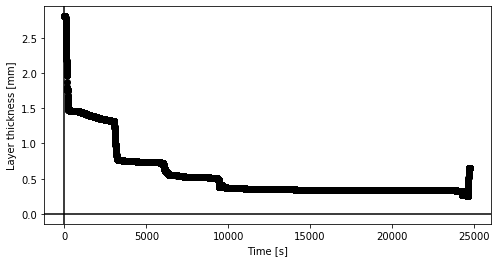

In [11]:
###########################################################
# insert rec number at which layer thickness was measured
rec_lt = 6068
# insert calculated value at that poin
val_lt = 0.73
###########################################################
# zero data
lt_ec_mm = rp.zero(lt_ec_mm,rec_lt)
lt_ec_mm = lt_ec_mm/2
lt_ec_mm = lt_ec_mm + val_lt

rp.plot(data.Time,lt_ec_mm,'Time [s]','Layer thickness [mm]')

### 6. Remove geometrical thinning

In [12]:
# default unit is [mm]
rgt_lt_mm = rp.rgt(lp_disp_mm,lt_ec_mm)

### 7. Calculate shear strain 

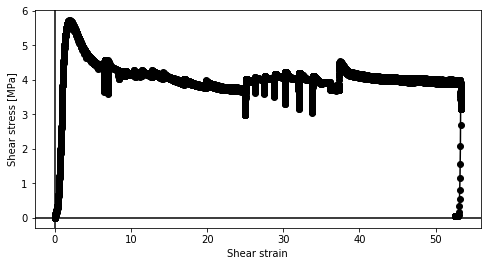

In [13]:
##### calculate strain ####
shear_strain_na = rp.shear_strain(ec_disp_mm,lt_ec_mm)

rp.plot(shear_strain_na,shear_stress_MPa,'Shear strain','Shear stress [MPa]')

### 8. Calculate friction 

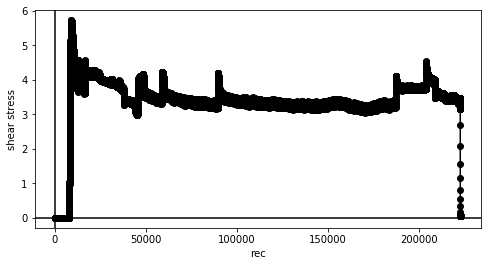

In [14]:
# select last row of experiment for friction
rp.plot(data.Record,shear_stress_MPa,'rec','shear stress')

In [15]:
##### insert the last row 
end_row = 208901
########################

friction_na = shear_stress_MPa/normal_stress_MPa
# remove the noise before and after vertical load
friction_na[:beg_row_v] = friction_na[:beg_row_v]*0
friction_na[end_row:] = friction_na[end_row:]*0

#rp.plot(ec_disp_mm,friction_na,'ec_disp [mm]','friction')

# Examples of additional functions

### Calculate derivative (e.g. shear velocity)

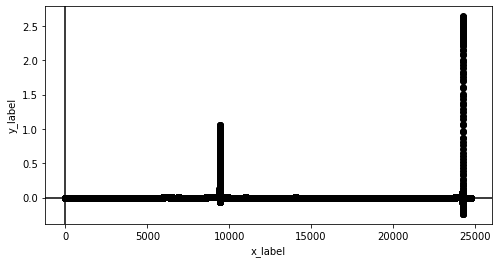

In [16]:
shear_vel_mms = rp.rslope(time_s,lp_disp_mm,20)
rp.plot(time_s,shear_vel_mms)

### Filter data 

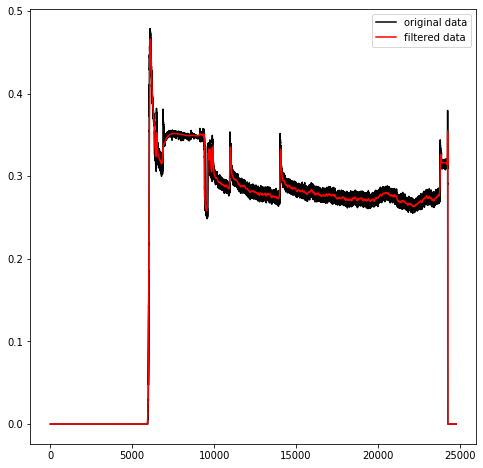

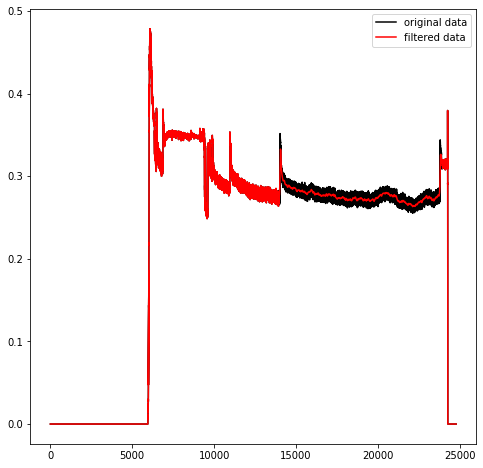

In [17]:
# you can filter al the experiment (not recommended)
mu_low_pass = rp.filter_low_pass(time_s,friction_na,0.01,10)
# you can filter only a portion of the experiment
mu_low_pass = rp.filter_low_pass(time_s,friction_na,0.01,10,rows=[89000,189000])

### Take the slope of a portion of the experiment

[-0.19174206  0.6646912 ]


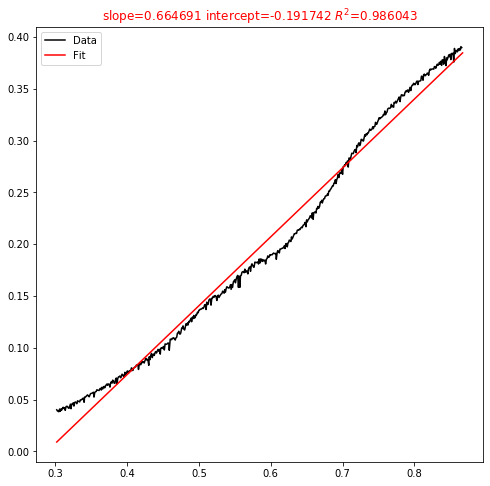

In [18]:
# coeff are from the lowest to highest order
coeff = rp.slope(lp_disp_mm,friction_na,7926,8490)
print (coeff)

[ -0.51334035   3.98099454 -10.94956166  14.35209173  -6.49268931]


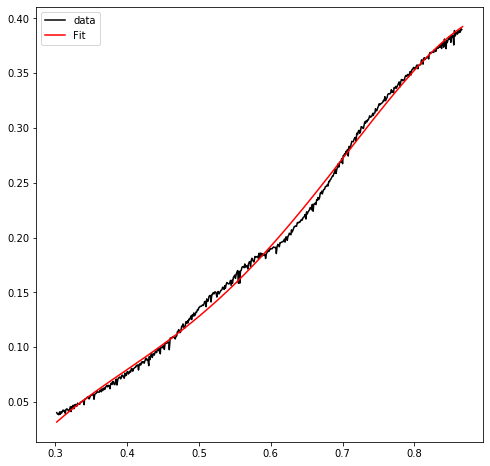

In [19]:
# or you can choose a higher polynominal fit
coeff = rp.slope(lp_disp_mm,friction_na,7926,8490,4)
print (coeff)

### 9. Export reduced data ###

In [20]:

data_out = [shear_stress_MPa,
            lp_disp_mm,
            ec_disp_mm, 
            normal_stress_MPa,
            lt_ec_mm, 
            rgt_lt_mm,
            friction_na,
            shear_strain_na, 
            time_s,
            records_na]
            
rp.save_data(exp_name,data_out,callingLocals=locals())

Saving data

------------------------------------------------------
|                Name|           Unit|        Records|
-----------------------------------------------------
|    shear_stress_MPa|            MPa|         223103|
|          lp_disp_mm|             mm|         223103|
|          ec_disp_mm|             mm|         223103|
|   normal_stress_MPa|            MPa|         223103|
|            lt_ec_mm|             mm|         223103|
|           rgt_lt_mm|             mm|         223103|
|         friction_na|             na|         223103|
|     shear_strain_na|             na|         223103|
|              time_s|              s|         223103|
|          records_na|             na|         223103|
------------------------------------------------------


# Compare the results obtained with rawPy against the same experiment analyzed with xlook

In [ ]:
## import the data analyzed as pandas data frame
exp_name = os.path.join(cwd, 'example', 'b754_data_rp')
data_rawPy = rp.load_data(exp_name,pandas=True)

In [ ]:
xlook_file = os.path.join(cwd, 'example', 'b754_xlook.txt')
data_xlook = pd.read_csv(xlook_file,skiprows=[1],delimiter=',')
data_xlook

In [ ]:
# compare ec_disp vs friction
f, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(data_xlook.ec_disp,data_xlook.mu,'k',label='xlook')
ax.plot(data_rawPy.ec_disp_mm, data_rawPy.friction_na,'r',label='rawPy')
ax.set_ylabel('Friction')
ax.set_xlabel('ec_disp [mm]')
ax.legend(loc='upper right')

In [ ]:
# compare shear_strain vs friction

f, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(data_xlook.Shear_Strain,data_xlook.mu,'k',label='xlook')
ax.plot(data_rawPy.shear_strain_na, data_rawPy.friction_na,'r',label='rawPy')
ax.set_ylabel('Friction')
ax.set_xlabel('shear strain')
ax.legend(loc='upper right')

In [ ]:
# compare time vs rgt (corrected layer thickness)

f, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(data_xlook.Time,data_xlook.rgt_LT,'k',label='xlook')
ax.plot(data_rawPy.time_s, data_rawPy.rgt_lt_mm*1000,'r',label='rawPy')
ax.set_ylabel('Friction')
ax.set_xlabel('shear strain')
ax.legend(loc='upper right')